In [61]:
import datetime
import rasterio as rs

def get_date(fl):
    
    year = fl.split('__')[-1].split('.')[0][11:15]
    month = fl.split('__')[-1].split('.')[0][15:17]
    day = fl.split('__')[-1].split('.')[0][17:19]
    
    return '%s-%s-%s'%(year,month,day)

def get_WaterYear(dt):
    
    strt = datetime.datetime(dt.year,10,1)
    nd = datetime.datetime(dt.year,12,31)
    
    if (dt >= strt) & (dt <= nd):
        return dt.year+1
    else:
        return dt.year

In [62]:
# generate a list of file names
files = pd.DataFrame()
files['name'] = glob.glob('./data/SNODAS_SWE/SnowWaterEquivalent/*/*.tif')
files['datetime'] = files.name.map(get_date)
files.index = pd.DatetimeIndex(files.datetime)
del files['datetime']
files['WaterYear'] = files.index.map(get_WaterYear)
files.sort_index(ascending=True,inplace=True)

In [63]:
waterYears = files.WaterYear.unique()

In [64]:
waterYears

array([2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016])

In [83]:
wy = 2006
fileList = files.loc[files.WaterYear==wy] # extract the files necessary
n = len(fileList) # number of files or raster stack depth

# load a test file to get the array dimensions
with rs.open(fileList.name[0]) as ds:
    j,k = ds.read(1).shape
    profile = ds.profile
    
tmp = np.ndarray((n,j,k)) # preallocate the array

i = 0
for fl in fileList.name:
    
    with rs.open(fl) as ds:
        d = ds.read(1)
        dd = np.array(d,dtype = np.float32)
        del d
        dd[dd==-9999] = np.NaN
        tmp[i,:,:] = dd/1000. # pull the data into the stack and scale it
    
    i += 1 
    
# reshape the array into a big data frame
cells = []
js = []
ks = []
for i in range(j):
    for o in range(k):
        cells.append(tmp[:,i,o])
        js.append(i)
        ks.append(o)

del tmp

dat = pd.DataFrame()
dat['jcoord'] = js
dat['kcoord'] = ks
dat['vals'] = cells

MemoryError: 

In [66]:
dates = fileList.index

In [67]:
def check_empty(vals):
    if np.sum(np.isnan(vals)) > 0:
        return 0
    else:
        return 1

In [68]:
dat['empty'] = dat.vals.map(check_empty)

In [69]:
def get_dons(vals):
    '''Pull the date of no snow'''
    if np.nansum(vals) > 1:
        dons = dates[np.argmin(vals)] # return the first date that the pack hits 0
        return dons
    else: return np.NaN
    
def get_peakSWE(vals):
    '''Pull the peak SWE value'''
    
    if np.nansum(vals) > 1:
        peakSWE = np.nanmax(vals)
        return peakSWE

    else:
        return np.NaN

def get_doPeakSWE(vals):
    '''Pull the date of peak SWE
    return a datetime object
    '''
    if np.nansum(vals) > 1:
        dops = dates[np.argmax(vals)] # return the last date that the pack maxes out
        return dops
    
    else: return np.NaN


In [70]:
dat['dons'] = dat.vals.map(get_dons)
dat['PeakSWE'] = dat.vals.map(get_peakSWE)
dat['doPeakSWE'] = dat.vals.map(get_doPeakSWE)

In [71]:
def DOWY(date):
    '''compute day of water year from a datetime object'''
    if np.isnan(date.year):
        return np.NaN
    else:
        year = int(date.year)
    
        if date <= datetime.datetime(year,10,1):
            return (date - datetime.datetime(year - 1,10,1)).days
        else: 
            return (date - datetime.datetime(year,10,1)).days

In [73]:
dat['dowy_noSnow'] = dat.dons.map(DOWY)
dat['dowy_peakSWE'] = dat.doPeakSWE.map(DOWY)

In [74]:
dowyNoSnow = np.ndarray((j,k),dtype = np.float32)
dowyPeakSWE = dowyNoSnow.copy()
PeakSWE = dowyNoSnow.copy()

dowyNoSnow[dat.jcoord,dat.kcoord] = dat.dowy_noSnow
dowyPeakSWE[dat.jcoord,dat.kcoord] = dat.dowy_peakSWE
PeakSWE[dat.jcoord,dat.kcoord] = dat.PeakSWE

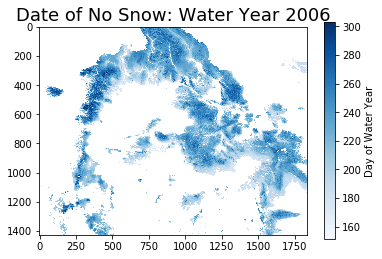

In [80]:
plt.imshow(dowyNoSnow,cmap='Blues')
plt.colorbar(label = 'Day of Water Year')
plt.title('Date of No Snow: Water Year %s'%wy,fontsize=18)

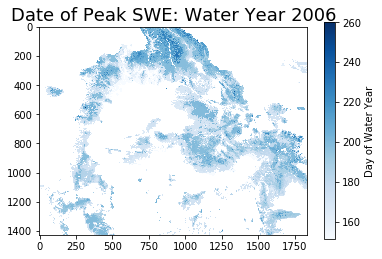

In [81]:
plt.imshow(dowyPeakSWE,cmap='Blues')
plt.colorbar(label = 'Day of Water Year')
plt.title('Date of Peak SWE: Water Year %s'%wy,fontsize=18)

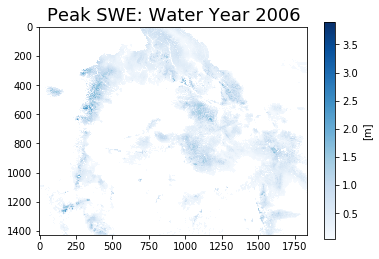

In [79]:
plt.imshow(PeakSWE,cmap='Blues')
plt.colorbar(label = '[m]')
plt.title('Peak SWE: Water Year %s'%wy,fontsize=18)

In [85]:
def savetiff(inarray,outfl,profile):
    with rs.open(outfl,'w',**profile) as ds:
        ds.write(inarray,1)

In [91]:
profile['dtype'] = 'float32' # fix profile

In [93]:
outfl = './data/snodas_peakSWE_wy%s.tiff'%wy
savetiff(PeakSWE,outfl,profile)

outfl = './data/snodas_DOWYpeakSWE_wy%s.tiff'%wy
savetiff(dowyPeakSWE,outfl,profile)

outfl = './data/snodas_DOWYnoSnow_wy%s.tiff'%wy
savetiff(dowyNoSnow,outfl,profile)

/home/tbarnhart/miniconda3/envs/py36/lib/python3.6/site-packages/rasterio/__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)
